# HPDM097 Assignment 2 Lab report and Code

## Background 

According to the National Institute for Health and Care Excellence (NICE) guidelines, all hospitals in England that admit patients with suspected or confirmed acute stroke should have access to an acute stroke unit (ASU). Among the most frequently diagnosed conditions are all subtypes of strokes, intracranial haemorrhages, thrombosis and transient ischaemic attacks (TIA). Due to high demand, ageing population and difficulties in training, recruiting and retaining medical staff, the NHS has been facing major issues with ASU staffing, thus compromising the availability and quality of its services. To ensure that ASUs can provide adequate care to all patients, the NHS trust has reached out for help in planning the future capacity of an ASU. 


## Objectives

We were tasked with building a simulation model of an ASU using the SimPy package, utilising the inter-arrival times and length of stay distribution data for each type of patient to answer the essential research questions:
1. To determine the required bed capacity to achieve the annual target of admitting 90% of patients to the stroke unit within 4 hours of their arrival at the hospital. 
2. To determine if the ASU can maintain a bed utilisation rate above 70% while achieving a 90% performance target. 
3. To understand the impact on the percentage of patients admitted to the stroke unit within 4 hours of arrival, bed occupancy, and the need for additional bed capacity of a 10% increase in patients requiring admission by 2030. 

## Methodology

For this project, we designed and built a discrete-event simulation model of the Acute Stroke Unit (ASU) using the SimPy simulation framework. The simulation model is capable of answering our research questions. The model considers three types of patients, who have suffered an acute stroke, transient ischaemic attack (TIA), and complex neurological conditions. The model also considers the interarrival time and length of stay distribution for each type of patient.

To build the simulation model, we used Python and the SimPy simulation framework. We used a discrete-event simulation approach to model the arrival and departure of patients in the ASU. We also made use of the Streamlit framework to develop a web-based interface to demonstrate the simulation. 

To evaluate the performance of the ASU, we conducted simulation runs for one year. The results obtained from the simulation runs were presented clearly and concisely. We also provided justifications for the recommendations made based on the simulation results.


## Imports

In [1]:
import numpy as np
import pandas as pd
import itertools
import math
import matplotlib.pyplot as plt
import simpy
from joblib import Parallel, delayed
import warnings
from scipy.stats import t
from treat_sim.distributions import Exponential, Lognormal

## Utility functions

In [2]:
def trace(msg):
    '''
    Utility function for printing simulation
    set the TRACE constant to FALSE to 
    turn tracing off.
    
    Params:
    -------
    msg: str
        string to print to screen.
    '''
    if TRACE:
        print(msg)

## Model parameters
 

In [34]:
# These are the parameters for a base case model run.

# run length in days
RUN_LENGTH = 365

# audit interval in days
DEFAULT_WARMUP_AUDIT_INTERVAL = 1

# default № of reps for multiple reps run
DEFAULT_N_REPS = 5

# default random number SET
DEFAULT_RNG_SET = None
N_STREAMS = 10

# Turn off tracing
TRACE = False

# resource counts
N_BEDS = 9

# time between arrivals in minutes (exponential)
# for acute stroke, TIA and neuro respectively
MEAN_IATs = [1.2, 9.5, 3.5]

# treatment (lognormal)
# for acute stroke, TIA and neuro respectively
TREAT_MEANs = [7.4, 1.8, 2.0]
TREAT_STDs = [8.5, 2.3, 2.5]

## Scenario class

In [4]:
class Scenario:
    '''
    Parameter container class for ASU model.
    '''

    def __init__(self, random_number_set=DEFAULT_RNG_SET):
        '''
        Initialize the Scenario object with default values.

        Parameters:
        ----------
        random_number_set: int, optional
            The random number set to be used by the simulation.
        '''

        # Warm-up period
        self.warm_up = 0.0

        # Default values for inter-arrival and treatment times
        self.iat_means = MEAN_IATs
        self.treat_means = TREAT_MEANs
        self.treat_stds = TREAT_STDs

        # Sampling
        self.random_number_set = random_number_set
        self.init_sampling()

        # Number of beds
        self.n_beds = N_BEDS

    def set_random_no_set(self, random_number_set):
        '''
        Set the random number set to be used by the simulation.

        Parameters:
        ----------
        random_number_set: int
            The random number set to be used by the simulation.
        '''
        self.random_number_set = random_number_set
        self.init_sampling()

    def init_sampling(self):
        '''
        Initialize the random number streams and create the distributions used by the simulation.
        '''

        # Create random number streams
        rng_streams = np.random.default_rng(self.random_number_set)

        # Initialize the random seeds for each stream
        self.seeds = rng_streams.integers(0, 999999999, size=N_STREAMS)

        # Create inter-arrival time distributions for each patient type
        self.arrival_dist_samples = {
            'stroke': Exponential(self.iat_means[0], random_seed=self.seeds[0]),
            'tia': Exponential(self.iat_means[1], random_seed=self.seeds[1]),
            'neuro': Exponential(self.iat_means[2], random_seed=self.seeds[2])
        }

        # Create treatment time distributions for each patient type
        self.treatment_dist_samples = {
            'stroke': Lognormal(self.treat_means[0], self.treat_stds[0], random_seed=self.seeds[3]),
            'tia': Lognormal(self.treat_means[1], self.treat_stds[1], random_seed=self.seeds[4]),
            'neuro': Lognormal(self.treat_means[2], self.treat_stds[2], random_seed=self.seeds[5])
        }

## Model building

In [5]:
class Patient:
    '''
    Patient in the ASU processes
    '''
    def __init__(self, identifier, patient_type, env, args):
        '''
        Constructor method
        
        Params:
        -----
        identifier: int
            a numeric identifier for the patient.
            
        env: simpy.Environment
            the simulation environment
            
        args: Scenario
            The input data for the scenario
        '''
        # patient id and environment
        self.identifier = identifier
        self.env = env
        
        # treatment parameters
        self.patient_type = patient_type
        self.beds = args.beds
        self.treatment_dist_samples = args.treatment_dist_samples
                
        # individual patient metrics
        self.queue_time = 0.0
        self.treat_time = 0.0
    
    def get_treatment_dist_sample(self):
        '''
        This method returns a sample from the treatment distribution of the patient, based on their type.
        '''
        self.treat_time = self.treatment_dist_samples[self.patient_type].sample()
        return self.treat_time
    
    def treatment(self):
        '''
        This method represents the patient's treatment process. The patient will request a bed, wait in the queue,
        and then undergo treatment before being discharged.
        '''
        # record the time that patient entered the system
        arrival_time = self.env.now
     
        # get a bed
        with self.beds.request() as req:
            yield req
            
            # calculate queue time and log it
            self.queue_time = self.env.now - arrival_time
            trace(f'Patient № {self.identifier} started treatment at {self.env.now:.3f};' 
                 + f' queue time was {self.queue_time:.3f}') 
            
            # wait for treatment to finish
            yield self.env.timeout(self.get_treatment_dist_sample())
            
            # discharge the patient
            self.patient_discharged()
    
    def patient_discharged(self):
        '''
        This method logs the patient's discharge and frees up the bed.
        '''
        trace(f'Patient № {self.identifier} discharged at {self.env.now:.3f}')

In [6]:
class MonitoredPatient(Patient):
    '''
    A MonitoredPatient class which monitors a patient process and notifies its observers 
    when a patient process has reached an event of completing treatment.
    
    This class implements the observer design pattern.
    '''
    
    def __init__(self, admissions_count, patient_type, env, args, model):
        '''
        Constructor for MonitoredPatient class.
        
        Params:
        -------
        admissions_count: int
            The identifier for the patient
            
        patient_type: str
            The type of patient, either 'stroke', 'tia', or 'neuro'
            
        env: simpy.Environment
            The simulation environment
            
        args: Scenario
            The input data for the scenario
            
        model: Model
            The model to be observed
        '''
        
        # Calls the constructor for the Patient superclass
        super().__init__(admissions_count, patient_type, env, args)
        
        # Creates a list of observers to notify
        self._observers = [model]
        
    def register_observer(self, observer):
        '''
        A method to register an observer to be notified when an event occurs.
        
        Params:
        -------
        observer: Observer
            The observer to be registered
        '''
        
        # Adds the observer to the list of observers
        self._observers.append(observer)
    
    def notify_observers(self, *args, **kwargs):
        '''
        A method to notify all registered observers when an event occurs.
        
        Params:
        -------
        *args: Any
            Positional arguments passed to the observer method
        
        **kwargs: Any
            Keyword arguments passed to the observer method
        '''
        
        # Calls the process_event method on each observer with the arguments passed
        for observer in self._observers: 
            observer.process_event(*args, **kwargs)
    
    def patient_discharged(self):
        '''
        A method to notify all observers that the patient has been discharged.
        '''
        
        # Calls the patient_discharged method on the Patient superclass
        super().patient_discharged()
        
        # Notifies all observers that the patient has been discharged
        self.notify_observers(self, 'patient_discharged')

In [7]:
class ASU:  
    '''
    Model of an ASU
    '''
    def __init__(self, args):
        '''
        Contructor
        
        Params:
        -------
        env: simpy.Environment
        
        args: Scenario
            container class for simulation model inputs.
        '''
        self.env = simpy.Environment()
        self.args = args 
        self.init_model_resources()
        self.patients = []
        
        self.admissions_count = 0
        
        self.stroke_count = 0
        self.tia_count = 0
        self.neuro_count = 0
        
        #running performance metrics:
        self.bed_wait = 0.0
        self.bed_util = 0.0
        
        self.patient_count = 0
            
        self.bed_occupation_time = 0.0
        
        
    def init_model_resources(self):
        '''
        Setup the simpy resource objects
        
        Params:
        ------
        args - Scenario
            Simulation Parameter Container
        '''

        self.args.beds = simpy.Resource(self.env, 
                                   capacity=self.args.n_beds)
        
        
    def run(self, results_collection_period = RUN_LENGTH,
            warm_up = 0):
        '''
        Conduct a single run of the model in its current 
        configuration

        run length = results_collection_period + warm_up

        Parameters:
        ----------
        results_collection_period, float, optional
            default = RUN_LENGTH

        warm_up, float, optional (default=0)
            length of initial transient period to truncate
            from results.

        Returns:
        --------
            None

        '''
        
        # setup the arrival processes
        self.env.process(self.arrivals_generator('stroke'))
        self.env.process(self.arrivals_generator('tia'))
        self.env.process(self.arrivals_generator('neuro'))
                
        # run
        self.env.run(until=results_collection_period+warm_up)
        
        
    def get_arrival_dist_sample(self):
        
        inter_arrival_time = self.args.arrival_dist_samples[self.patient_type].sample()
        return inter_arrival_time
            
        
    def arrivals_generator(self, patient_type):
        self.args.init_sampling()
            
        while True:
                
            self.patient_type = patient_type
            
            if self.env.now > self.args.warm_up:
                if self.patient_type == 'stroke':
                    self.stroke_count += 1
                elif self.patient_type == 'tia':
                    self.tia_count += 1
                else:
                    self.neuro_count += 1    

            iat = self.get_arrival_dist_sample()
            yield self.env.timeout(iat)
                
            self.admissions_count += 1

            trace(f'Patient № {self.admissions_count} ({patient_type}) arrives at {self.env.now:.3f}')
                
            new_patient = MonitoredPatient(self.admissions_count, patient_type, self.env, self.args, self)                

            self.env.process(new_patient.treatment())                 
                
            if self.env.now > self.args.warm_up:
                    
                # keep a record of the patient for results calculation
                self.patients.append(new_patient)                
    
    
    def process_event(self, *args, **kwargs):
        '''
        Running calculates each time a Patient process ends
        (when a patient departs the simulation model)
        
        Params:
        --------
        *args: list
            variable number of arguments. This is useful in case you need to
            pass different information for different events
        
        *kwargs: dict
            keyword arguments.  Same as args, but you can is a dict so you can
            use keyword to identify arguments.
        
        '''
        patient = args[0]
        msg = args[1]
        
        #only run if warm up complete
        if self.env.now < self.args.warm_up:
            return

        if msg == 'patient_discharged':
            self.patient_count += 1
            n = self.patient_count
            
            #running calculation for mean bed waiting time
            self.bed_wait += \
                (patient.queue_time - self.bed_wait) / n

            #running calc for mean bed utilisation
            self.bed_occupation_time += patient.treat_time

                
                
    def run_summary_frame(self):
        
        '''
        Utility function for final metrics calculation.

        Returns a pandas DataFrame containing summary statistics of the simulation.
        '''
        
        # adjust util calculations for warmup period
        rc_period = self.env.now - self.args.warm_up
        util = self.bed_occupation_time / (rc_period * self.args.n_beds)
        
        # create nparray of all queue times, convert to hours
        patients_queue_times = np.array([patient.queue_time * 24 for patient in self.patients])
        
        # Find the value at the 90th percentile
        pct_90 = np.percentile(patients_queue_times, 90)

        # Filter out any values above the 90th percentile
        filtered_times = patients_queue_times[patients_queue_times <= pct_90]

        # Calculate the mean of the filtered times
        bed_wait_90 = np.mean(filtered_times) 
        

        # calculate proportion of patient with queue time less than 4 hrs
        percent_4_less = (sum(qt <= 4 for qt in patients_queue_times) / len(self.patients)) * 100
        
        bed_wait = self.bed_wait * 24


        df = pd.DataFrame({'1':{'1a Total Patient Arrivals':self.patient_count,
                                '1b Stroke Patient Arrivals':self.stroke_count,
                                '1c TIA Patient Arrivals':self.tia_count,
                                '1d Neuro Patient Arrivals':self.neuro_count,
                                '2 Mean Queue Time (hrs)':bed_wait,
                                '3 Mean Queue Time of Bottom 90% (hrs)': bed_wait_90,
                                '4 Patients Admitted within 4 hrs of arrival(%)': percent_4_less,
                                '5 Bed Utilisation (%)': util*100}})

                                
        df = df.T
        df.index.name = 'rep'
        return df

## Functions for single and multiple runs

In [8]:
def single_run(scenario, 
               rc_period = RUN_LENGTH, 
               warm_up = 0,
               random_no_set = DEFAULT_RNG_SET):
    '''
    Perform a single run of the model and return the results
    
    Parameters:
    -----------
    
    scenario: Scenario object
        The scenario/paramaters to run
        
    rc_period: int
        The length of the simulation run that collects results
        
    warm_up: int, optional (default=0)
        warm-up period in the model.  The model will not collect any results
        before the warm-up period is reached.  
        
    random_no_set: int or None, optional (default=1)
        Controls the set of random seeds used by the stochastic parts of the 
        model.  Set to different ints to get different results.  Set to None
        for a random set of seeds.
        
    Returns:
    --------
        pandas.DataFrame:
        results from single run.
    '''  
        
    # set random number set - this controls sampling for the run.
    if random_no_set is not None:
        scenario.set_random_no_set(random_no_set)
    
    scenario.warm_up = warm_up
    
    # create the model
    model = ASU(scenario)

    model.run(results_collection_period = rc_period, warm_up = warm_up)
    
    # run the model
    results_summary= model.run_summary_frame()
    
    return results_summary

In [9]:
def multiple_replications(scenario, 
                          rc_period=RUN_LENGTH,
                          warm_up=0,
                          n_reps=DEFAULT_N_REPS, 
                          n_jobs=-1,
                          random_no_set=DEFAULT_RNG_SET):
    '''
    Perform multiple replications of the model.
    
    Params:
    ------
    scenario: Scenario
        Parameters/arguments to configurethe model
    
    rc_period: float, optional (default=DEFAULT_RESULTS_COLLECTION_PERIOD)
        results collection period.  
        the number of minutes to run the model beyond warm up
        to collect results
    
    warm_up: float, optional (default=0)
        initial transient period.  no results are collected in this period

    n_reps: int, optional (default=DEFAULT_N_REPS)
        Number of independent replications to run.

    n_jobs, int, optional (default=-1)
        No. replications to run in parallel.
        
        
    Returns:
    --------
    List
    '''    
    
    if random_no_set is not None:
        rng_sets = [random_no_set + rep for rep in range(n_reps)]
    else:
        rng_sets = [None] * n_reps
       
    res = Parallel(n_jobs=n_jobs)(delayed(single_run)(scenario, 
                                                      rc_period, 
                                                      warm_up, 
                                                      random_no_set=rng_set) 
                                    for rng_set in rng_sets)
    

    # format and return results in a dataframe
    df_results = pd.concat(res)
    df_results.index = np.arange(1, len(df_results)+1)
    df_results.index.name = 'rep'
    return df_results


# Scripts to run the model

In [11]:
# SINGLE RUN

# base case scenario with default parameters
default_args = Scenario()

print('Running simulation ...', end = ' => ')
results = single_run(default_args, warm_up=250)
print('simulation complete.')

results

Running simulation ... => simulation complete.


,1a Total Patient Arrivals,1b Stroke Patient Arrivals,1c TIA Patient Arrivals,1d Neuro Patient Arrivals,2 Mean Queue Time (hrs),3 Mean Queue Time of Bottom 90% (hrs),4 Patients Admitted within 4 hrs of arrival(%),5 Bed Utilisation (%)
rep,,,,,,,,
1,450.0,291.0,32.0,123.0,23.257627,7.943449,67.040359,77.369717


In [12]:
# MULTIPLE RUN

# default scenario
args = Scenario()

# run multiple replications.
# by default it runs 5 replications.
print('Running multiple replications', end=' => ')
results  = multiple_replications(args, n_reps=51, warm_up=250, random_no_set=333)
print('done.\n')

# show reps rounded to 2dp
results.round(2).head()

Running multiple replications => done.



,1a Total Patient Arrivals,1b Stroke Patient Arrivals,1c TIA Patient Arrivals,1d Neuro Patient Arrivals,2 Mean Queue Time (hrs),3 Mean Queue Time of Bottom 90% (hrs),4 Patients Admitted within 4 hrs of arrival(%),5 Bed Utilisation (%)
rep,,,,,,,,
1,435.0,275.0,43.0,105.0,10.02,1.88,80.61,69.49
2,446.0,294.0,41.0,111.0,15.29,4.55,73.09,77.67
3,436.0,290.0,41.0,107.0,8.29,3.38,75.80,65.15
4,444.0,308.0,38.0,94.0,19.27,5.62,71.82,75.60
5,443.0,313.0,30.0,98.0,27.96,13.51,62.81,79.99


In [13]:
results.mean()

1a Total Patient Arrivals                         446.980392
1b Stroke Patient Arrivals                        305.882353
1c TIA Patient Arrivals                            39.862745
1d Neuro Patient Arrivals                         101.862745
2 Mean Queue Time (hrs)                            25.337481
3 Mean Queue Time of Bottom 90% (hrs)              13.343393
4 Patients Admitted within 4 hrs of arrival(%)     66.289279
5 Bed Utilisation (%)                              76.169494
dtype: float64

## Warmup period calculation

This is needed to make sure that we store and analyse our metrics only when the model reaches its stable state. We would add the warm-up time to the overall model execution length and would only start storing metrics after the warm-up time has passed.

In [14]:
class WarmupAuditor():
    '''
    Warmup Auditor for the model.
    
    Stores the cumulative means for:
    1. bed waiting time
    2. bed utilisation.
    
    '''
    def __init__(self, model, interval=DEFAULT_WARMUP_AUDIT_INTERVAL):
        self.env = model.env
        self.model = model
        self.interval = interval
        self.bed_wait = []
        self.bed_util = []
        
    def run(self, rc_period):
        '''
        Run the audited model
        
        Parameters:
        ----------
        rc_period: float
            Results collection period.  Typically this should be many times
            longer than the expected results collection period.
            
        Returns:
        -------
        None.
        '''
        # set up data collection for warmup variables.
        self.env.process(self.audit_model())
        self.model.run(rc_period, 0)
        
    def audit_model(self):
        '''
        Audit the model at the specified intervals
        '''
        for i in itertools.count():
            yield self.env.timeout(self.interval)

            
            # Performance metrics
            # calculate the utilisation metrics
            util = self.model.bed_occupation_time / \
                (self.env.now * self.model.args.n_beds)
            
            
            # store the metrics
            self.bed_wait.append(self.model.bed_wait)
            self.bed_util.append(util)

            
    def summary_frame(self):
        '''
        Return the audit observations in a summary dataframe
        
        Returns:
        -------
        pd.DataFrame
        '''
        
        df = pd.DataFrame([self.bed_wait,
                           self.bed_util]).T
        df.columns = ['bed_wait', 'bed_util']
        
        return df

    
def warmup_single_run(scenario, rc_period, 
                      interval=DEFAULT_WARMUP_AUDIT_INTERVAL, 
                      random_no_set=DEFAULT_RNG_SET):
    '''
    Perform a single run of the model as part of the warm-up
    analysis.
    
    Parameters:
    -----------
    
    scenario: Scenario object
        The scenario/paramaters to run
        
    results_collection_period: int
        The length of the simulation run that collects results
               
    audit_interval: int, optional (default=60)
        during between audits as the model runs.
        
    Returns:
    --------
        Tuple:
        (mean_time_in_system, mean_time_to_nurse, mean_time_to_triage,
         four_hours)
    '''        
    
    # set random number set - this controls sampling for the run.
    if random_no_set is not None:
        scenario.set_random_no_set(random_no_set)

    # create an instance of the model
    model = ASU(scenario)

    # create warm-up model auditor and run
    audit_model = WarmupAuditor(model, interval)
    audit_model.run(rc_period)

    return audit_model.summary_frame()


def warmup_analysis(scenario, rc_period, n_reps=DEFAULT_N_REPS,
                    interval=DEFAULT_WARMUP_AUDIT_INTERVAL,
                    n_jobs=-1):
                   # random_no_set=DEFAULT_RNG_SET):
    '''
    Conduct a warm-up analysis of key performance measures in the model.
    
    The analysis runs multiple replications of the model.
    In each replication a WarmupAuditor periodically takes observations
    of the following metrics:

    metrics included:
    1. Operator waiting time
    2. Nurse callback waiting time
    3. Operator utilisation
    4. Nurse utilisation

    Params:
    ------
    scenario: Scenario
        Parameters/arguments to configurethe model
    
    rc_period: int
        number of minutes to run the model in simulated time
        
    n_reps: int, optional (default=5)
        Number of independent replications to run.

    n_jobs: int, optional (default=-1)
        Number of processors for parallel running of replications

    Returns:
    --------
    dict of pd.DataFrames where each dataframe related to a metric.
    Each column of a dataframe represents a replication and each row 
    represents an observation.
    '''    
    
    res = Parallel(n_jobs=n_jobs)(delayed(warmup_single_run)(scenario, 
                                                             rc_period,
                                                             random_no_set=rep,
                                                             interval=interval) 
                                  for rep in range(n_reps))
       
    # format and return results
    metrics = {'bed_wait':[],
               'bed_util':[]}

    # preprocess results of each replication
    for rep in res:
        metrics['bed_wait'].append(rep.bed_wait)
        metrics['bed_util'].append(rep.bed_util)
        
    # cast to dataframe
    metrics['bed_wait'] = pd.DataFrame(metrics['bed_wait']).T
    metrics['bed_util'] = pd.DataFrame(metrics['bed_util']).T
    
    # index as obs number
    metrics['bed_wait'].index = np.arange(1, len(metrics['bed_wait'])+1)
    metrics['bed_util'].index = np.arange(1, len(metrics['bed_util'])+1)

    # obs label
    metrics['bed_wait'].index.name = "audit"
    metrics['bed_util'].index.name = "audit"
    
    # columns as rep number
    cols = [f'rep_{i}' for i in range(1, n_reps+1)]
    metrics['bed_wait'].columns = cols
    metrics['bed_util'].columns = cols
    
    return metrics

In [15]:
%%time
# script
# note this will take 5-30 seconds to run depending on your machine

# default scenario
args = Scenario()

N_REPS=10

RUN_LENGTH=730

#run warm up analysis for scenario
print('Running warm-up analysis with replications. Please wait...', end=' => ')
results = warmup_analysis(args, rc_period=RUN_LENGTH, n_reps=N_REPS)
print('done.')

Running warm-up analysis with replications. Please wait... => done.
CPU times: total: 344 ms
Wall time: 1.4 s


In [16]:
results['bed_util'].head()

,rep_1,rep_2,rep_3,rep_4,rep_5,rep_6,rep_7,rep_8,rep_9,rep_10
audit,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040881,0.000000,0.000000,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020441,0.000000,0.014336,0.0
3,0.000000,0.000000,0.000000,0.058661,0.000000,0.120237,0.013627,0.000000,0.052656,0.0
4,0.050711,0.055836,0.000000,0.140704,0.000000,0.109383,0.269749,0.000000,0.039492,0.0
5,0.061172,0.044668,0.102852,0.112563,0.090258,0.188352,0.423300,0.063463,0.031593,0.0


In [17]:
def time_series_inspection(results, warm_up=None):
    '''
    Time series inspection method
    
    Parameters:
    ----------
    results: dict
        The dict of results taken from warmup_analysis
    '''
    
    # create the 4 chart areas to plot
    fig, ax = plt.subplots(1, 2, figsize=(12,4.5))
    
    # take the mean of the columns for each metric and plot
    ax[0].plot(results['bed_wait'].mean(axis=1))
    ax[1].plot(results['bed_util'].mean(axis=1))

    # set the label of each chart
    ax[0].set_ylabel('bed_wait')
    ax[1].set_ylabel('bed_util')

    if warm_up is not None:
        #add warmup cut-off vertical line if one is specified
        ax[0].axvline(x=warm_up, color='red', ls='--')
        ax[1].axvline(x=warm_up, color='red', ls='--')
    
    return fig, ax

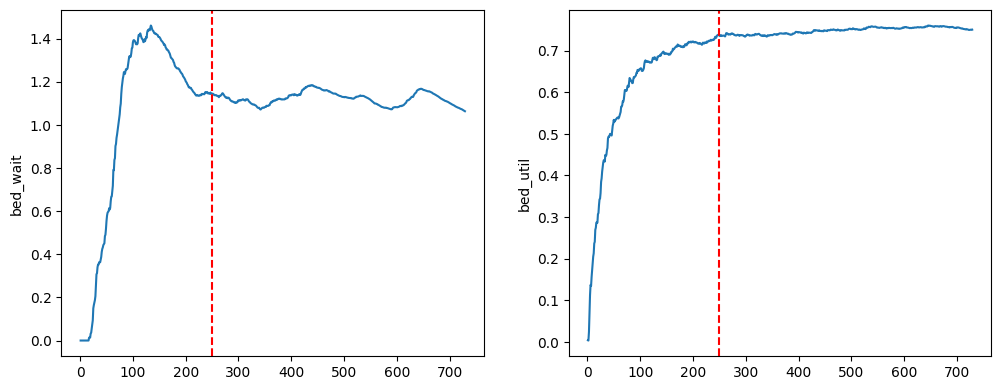

In [18]:
# this assumes you assigned the output of warmup_analysis to a varible 'results'
fig, ax = time_series_inspection(results, warm_up=250) #9 beds

## Estimating the number of replications

This is done to calculate the minimal amount of model iterations needed to obtain valid and precise results.

In [19]:
%%time 

WARM_UP = 250

RUN_LENGTH = 365

# number of replications
N_REPS = 100

# default scenario
args = Scenario()

# run multiple replications.
print('Running multiple replications', end=' => ')
replications  = multiple_replications(args, rc_period=RUN_LENGTH, warm_up=WARM_UP,
                                      n_reps=N_REPS)

print('done.\n')

# show results summary rounded to 2dp
replications.describe().round(2)

Running multiple replications => done.

CPU times: total: 1 s
Wall time: 4.52 s


,1a Total Patient Arrivals,1b Stroke Patient Arrivals,1c TIA Patient Arrivals,1d Neuro Patient Arrivals,2 Mean Queue Time (hrs),3 Mean Queue Time of Bottom 90% (hrs),4 Patients Admitted within 4 hrs of arrival(%),5 Bed Utilisation (%)
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
mean,448.96,306.81,38.07,104.10,29.32,16.15,64.40,77.13
std,22.38,18.64,6.22,10.81,27.14,21.52,13.90,6.00
min,390.00,269.00,25.00,76.00,4.65,0.04,15.60,61.24
25%,434.00,292.00,34.00,96.75,11.23,3.43,55.94,72.68
50%,447.50,304.00,38.00,104.50,21.93,10.06,65.94,77.16
75%,464.50,323.00,42.00,110.00,36.36,19.46,74.70,81.04
max,500.00,344.00,54.00,132.00,198.05,164.91,89.29,90.60


In [20]:
def confidence_interval_method(replications, alpha=0.05, desired_precision=0.05, 
                               min_rep=5, decimal_place=2):
    '''
    The confidence interval method for selecting the number of replications
    to run in a simulation.
    
    Finds the smallest number of replications where the width of the confidence
    interval is less than the desired_precision.  
    
    Returns both the number of replications and the full results dataframe.
    
    Parameters:
    ----------
    replications: arraylike
        Array (e.g. np.ndarray or list) of replications of a performance metric
        
    alpha: float, optional (default=0.05)
        procedure constructs a 100(1-alpha) confidence interval for the 
        cumulative mean.
        
    desired_precision: float, optional (default=0.05)
        Desired mean deviation from confidence interval.
        
    min_rep: int, optional (default=5)
        set to a integer > 0 and ignore all of the replications prior to it 
        when selecting the number of replications to run to achieve the desired
        precision.  Useful when the number of replications returned does not
        provide a stable precision below target.
        
    decimal_places: int, optional (default=2)
        sets the number of decimal places of the returned dataframe containing
        the results
    
    Returns:
    --------
        tuple: int, pd.DataFrame
    
    '''
    n = len(replications)
    cumulative_mean = [replications[0]]
    running_var = [0.0]
    for i in range(1, n):
        cumulative_mean.append(cumulative_mean[i-1] + \
                       (replications[i] - cumulative_mean[i-1] ) / (i+1))
        
        # running biased variance
        running_var.append(running_var[i-1] + (replications[i] 
                                               - cumulative_mean[i-1]) \
                            * (replications[i] - cumulative_mean[i]))
        
    # unbiased std dev = running_var / (n - 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        running_std = np.sqrt(running_var / np.arange(n))
    
    # half width of interval
    dof = len(replications) - 1
    t_value = t.ppf(1 - (alpha / 2),  dof)    
    with np.errstate(divide='ignore', invalid='ignore'):
        std_error = running_std / np.sqrt(np.arange(1, n+1))
        
    half_width = t_value * std_error
        
    # upper and lower confidence interval
    upper = cumulative_mean + half_width
    lower = cumulative_mean - half_width
    
    # Mean deviation
    with np.errstate(divide='ignore', invalid='ignore'):
        deviation = (half_width / cumulative_mean) * 100
    
    # commbine results into a single dataframe
    results = pd.DataFrame([replications, cumulative_mean, 
                            running_std, lower, upper, deviation]).T
    results.columns = ['Mean', 'Cumulative Mean', 'Standard Deviation', 
                       'Lower Interval', 'Upper Interval', '% deviation']
    results.index = np.arange(1, n+1)
    results.index.name = 'replications'
    
    # get the smallest no. of reps where deviation is less than precision target
    try:
        n_reps = results.iloc[min_rep:].loc[results['% deviation'] 
                             <= desired_precision*100].iloc[0].name
    except:
        # no replications with desired precision
        message = 'WARNING: the replications do not reach desired precision'
        warnings.warn(message)
        n_reps = -1 

    
    return n_reps, results.round(2)
        

In [21]:
# run the method on the operator_wait replications
n_reps, conf_ints = \
    confidence_interval_method(replications['2 Mean Queue Time (hrs)'].to_numpy(),
                               desired_precision=0.05)

# print out the min number of replications to achieve precision
print(f'\nminimum number of reps for 5% precision: {n_reps}\n')

# peek at table of results
conf_ints.head()


minimum number of reps for 5% precision: -1



C:\Users\User\AppData\Local\Temp\ipykernel_800\1893281968.py:86: UserWarning: WARNING: the replications do not reach desired precision
  warnings.warn(message)


,Mean,Cumulative Mean,Standard Deviation,Lower Interval,Upper Interval,% deviation
replications,,,,,,
1,4.76,4.76,NaN,NaN,NaN,NaN
2,9.61,7.19,3.42,2.38,11.99,66.87
3,16.24,10.20,5.76,3.60,16.80,64.68
4,12.19,10.70,4.81,5.93,15.47,44.58
5,5.02,9.57,4.88,5.24,13.89,45.24


In [22]:
def plot_confidence_interval_method(n_reps, conf_ints, metric_name, 
                                    figsize=(12,4)):
    '''
    Plot the confidence intervals and cumulative mean
    
    Parameters:
    ----------
    n_reps: int
        minimum number of reps selected
        
    conf_ints: pandas.DataFrame
       results of the `confidence_interval_method` function
       
    metric_name: str
        Name of the performance measure
        
    figsize: tuple, optional (default=(12,4))
        The size of the plot
        
    Returns:
    -------
        matplotlib.pyplot.axis
    '''
    # plot cumulative mean + lower/upper intervals
    ax = conf_ints[['Cumulative Mean', 'Lower Interval', 
                         'Upper Interval']].plot(figsize=figsize)
    # add the 
    ax.axvline(x=n_reps, ls='--', color='red')
    
    ax.set_ylabel(f'cumulative mean: {metric_name}')
    
    return ax

Didn't manage to calculate the number if replications based on mean bed waiting time. Though if you look at the graph, the number of 51 derived from the further estimations seems like a good fit.

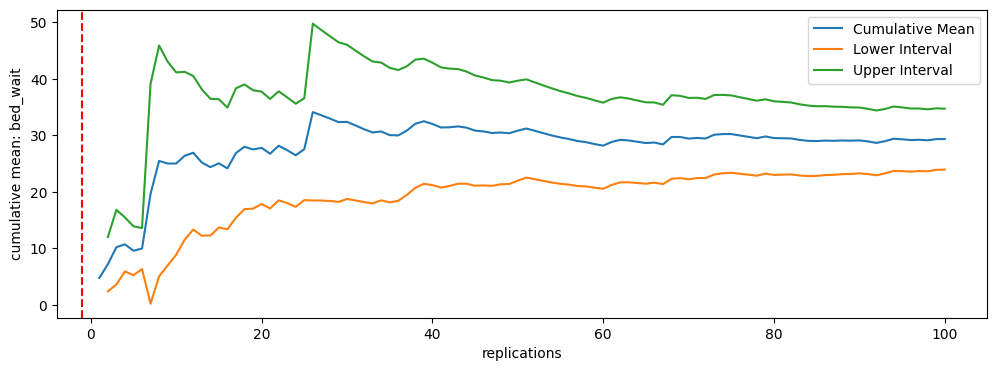

In [23]:
# plot the confidence intervals
ax = plot_confidence_interval_method(n_reps, conf_ints, 
                                     metric_name='bed_wait')

Analysis of replications for bed utilisation...

minimum number of reps for 5% precision: 51



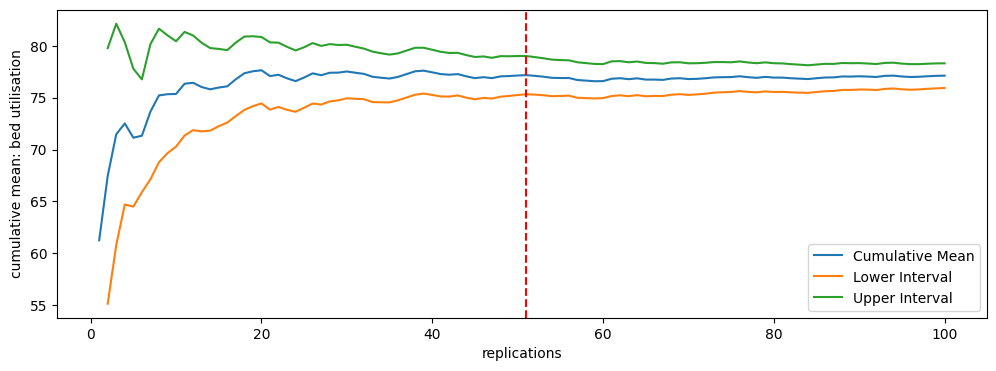

In [24]:
# run the method on the opts util replications
# We already know that we have to run > 50 reps so set min_rep parameter = 50.
n_reps, conf_ints = \
    confidence_interval_method(replications['5 Bed Utilisation (%)'].to_numpy(),
                               desired_precision=0.05, min_rep=50)

print('Analysis of replications for bed utilisation...')

#print out the min number of replications to achieve precision
print(f'\nminimum number of reps for 5% precision: {n_reps}\n')

#plot the confidence intervals
ax = plot_confidence_interval_method(n_reps, conf_ints, 
                                     metric_name='bed utilisation')

In [25]:
def get_scenarios():
    '''
    Creates a dictionary object containing
    objects of type `Scenario` to run.
    
    Returns:
    --------
    dict
        Contains the scenarios for the model
    '''
    scenarios = {}
    scenarios['base'] = Scenario()
    
    scenarios['beds_10'] = Scenario()
    scenarios['beds_10'].n_beds += 1
    
    scenarios['beds_11'] = Scenario()
    scenarios['beds_11'].n_beds += 2
    
    scenarios['beds_12'] = Scenario()
    scenarios['beds_12'].n_beds += 3
    
    scenarios['beds_13'] = Scenario()
    scenarios['beds_13'].n_beds += 4
    
    scenarios['beds_14'] = Scenario()
    scenarios['beds_14'].n_beds += 5    
    
    
    return scenarios

In [35]:
def run_scenario_analysis(scenarios, rc_period, warm_up, n_reps):
    '''
    Run each of the scenarios for a specified results
    collection period, warmup and replications.
    
    (note if you have lots of scenarios this may take several minutes)
    '''
    print('Scenario Analysis')
    print(f'No. Scenario: {len(scenarios)}')
    print(f'Replicatins: {n_reps}')
    
    
    scenario_results = {}
    for sc_name, scenario in scenarios.items():
        
        print(f'Running {sc_name}', end=' => ')
        replications  = multiple_replications(scenario, rc_period=RC_PERIOD, 
                                              warm_up=warm_up,
                                              n_reps=n_reps,
                                              random_no_set=333)
        print('done.\n')
        
        #save the results
        scenario_results[sc_name] = replications
    
    print('Scenario analysis complete.')
    return scenario_results

In [36]:
%%time
# script to run model

# set models warmup period
WARM_UP = 250

# results collection over a single day
RC_PERIOD = 365

# number of replications
N_REPS = 51

# get the scenarios
scenarios = get_scenarios()

# run the scenario analysis
scenario_results = run_scenario_analysis(scenarios, RC_PERIOD, WARM_UP,
                                         N_REPS)

Scenario Analysis
No. Scenario: 6
Replicatins: 51
Running base => done.

Running beds_10 => done.

Running beds_11 => done.

Running beds_12 => done.

Running beds_13 => done.

Running beds_14 => done.

Scenario analysis complete.
CPU times: total: 3.36 s
Wall time: 14.4 s


In [37]:
def scenario_summary_frame(scenario_results):
    '''
    Mean results for each performance measure by scenario
    
    Parameters:
    ----------
    scenario_results: dict
        dictionary of replications.  
        Key identifies the performance measure
        
    Returns:
    -------
    pd.DataFrame
    '''
    columns = []
    summary = pd.DataFrame()
    for sc_name, replications in scenario_results.items():
        summary = pd.concat([summary, replications.mean()], axis=1)
        columns.append(sc_name)

    summary.columns = columns
    return summary

In [33]:
summary_frame = scenario_summary_frame(scenario_results)
summary_frame.round(2)

,base,beds_10,beds_11,beds_12,beds_13,beds_14
1a Total Patient Arrivals,446.98,447.65,447.69,447.76,447.92,447.98
1b Stroke Patient Arrivals,305.88,305.88,305.88,305.88,305.88,305.88
1c TIA Patient Arrivals,39.86,39.86,39.86,39.86,39.86,39.86
1d Neuro Patient Arrivals,101.86,101.86,101.86,101.86,101.86,101.86
2 Mean Queue Time (hrs),25.34,9.67,4.07,1.72,0.69,0.27
3 Mean Queue Time of Bottom 90% (hrs),13.34,2.92,0.52,0.08,0.00,0.00
4 Patients Admitted within 4 hrs of arrival(%),66.29,81.20,89.98,94.76,97.40,98.84
5 Bed Utilisation (%),76.17,68.66,62.42,57.24,52.85,49.09


The results indicate that by incrementing the number of beds for simulation, at least 11 beds are required to achieve the goal of admitting 90% of patients to the stroke unit within 4 hours of their arrival at the hospital. Based on the current model parameters, it is impossible to maintain bed utilization above 70%, with our calculation for 11 beds being 62,42%. Further increase in the number of beds would be beneficial in terms of reducing queue times to no waiting time of bottom 90% of patients with a ward equipped with 12 beds, though bed utilization would drop significantly which may not be reasonable financially.

In [38]:
# after manually changing the MEAN_IATs to [1.08, 8.55, 3.15]
# for acute stroke, TIA and neuro respectively
# and rerunning cells starting from def run_scenario_analysis...
summary_frame = scenario_summary_frame(scenario_results)
summary_frame.round(2)

,base,beds_10,beds_11,beds_12,beds_13,beds_14
1a Total Patient Arrivals,498.22,499.53,500.06,499.80,499.76,499.86
1b Stroke Patient Arrivals,340.65,340.65,340.65,340.65,340.65,340.65
1c TIA Patient Arrivals,44.12,44.12,44.12,44.12,44.12,44.12
1d Neuro Patient Arrivals,114.92,114.92,114.92,114.92,114.92,114.92
2 Mean Queue Time (hrs),61.55,21.47,8.57,3.63,1.55,0.62
3 Mean Queue Time of Bottom 90% (hrs),43.73,11.33,2.65,0.46,0.05,0.00
4 Patients Admitted within 4 hrs of arrival(%),47.41,68.27,81.75,90.17,94.86,97.48
5 Bed Utilisation (%),84.78,76.45,69.58,63.75,58.84,54.67


We also analyzed the impact of a 10% increase in patient admissions by 2030. Increasing bed capacity to 12 would be necessary to maintain the goal of admitting 90% of patients to the stroke unit within 4 hours of their arrival at the hospital. Bed utilization would be 63.75%, no way to achieve 70%+.

## Discussion

The results suggest that increasing the number of beds in the stroke unit is important to improve stroke care. The findings from the simulation of 2030 highlight the importance of planning for future increases in patient volumes and underscore the need for hospitals to invest in resources, such as bed capacity and staffing to meet growing demand.

The simulation also demonstrates that both the mean treatment waiting time and the percentage of patients admitted to the stroke unit within 4 hours of arrival decreased with the bed utilization increased. It indicates that more beds might not necessarily lead to a decrease in waiting time for patients. 

Adding more complexity to a simulation model can be beneficial to the model. We could change the arrival rate and treatment time distributions based on the seasons. This could provide a more comprehensive understanding of the ASU and allow for more informed decision-making by the managers. However, it is important to balance the level of complexity with the available data and resources.


## Conclusion 

This project aimed to build a simulation model using the SimPy package to help plan for future capacity and optimize resource allocation in an acute stroke unit (ASU). The model considered inter-arrival times and length of stay distributions for three types of patients and was capable of answering questions related to bed capacity, bed utilization rate, and the impact of future patient volume.

The results indicated that 9 beds are insufficient to achieve the goal of admitting 90% of patients to the stroke unit within 4 hours of their arrival at the hospital while maintaining a bed utilization of around 70%. Increasing the number of beds to at least 11 is necessary to achieve this goal. Additionally, the results suggest that hospitals should plan for future increases in patient volume and invest in resources, such as bed capacity and staffing, to meet growing demand.

Overall, the simulation model developed in this project provides valuable insights for hospitals seeking to improve stroke care and optimize resource allocation in acute stroke units.

In future work, it might be beneficial to increase the complexity of the simulation model by incorporating seasonal variations in arrival rates and treatment times, and by considering additional patient characteristics, such as age and comorbidities. However, it is important to balance the level of complexity with available data and resources.
